In [1]:
import numpy as np
import pickle

from gpu import set_gpu
from matplotlib import pyplot as plt
import loop as lp
set_gpu()

Num GPUs Available:  1


In [2]:
sub_type = 'TR'
with open('train_data_raw_'  + sub_type + '.p', 'rb') as f:
    raw, params,feat,feat_sq = pickle.load(f)

In [3]:
import loop as lp
last_acc = np.full([5, 10,4],np.nan)
last_val = np.full([5, 10,4],np.nan)
i = 0
lat = 4

# loop through subjects
for sub_i in range(1,2):
    temp_acc, temp_val, file_name, x_noise, x_clean, y_train, scaler, gen_clf, dec_out = lp.loop_cv(raw, params, sub_type, n_train='fullgaussflat4', load=True, train_scale=5, epochs= 50, batch_size = 128, sparsity=True,dt='cv',feat_type='feat',noise=True, latent_dim=lat,sub=sub_i,mod = ['recon','gen'],gens=100)
    last_acc[sub_i-1,i,:] = np.nanmean(temp_acc,axis=0)
    last_val[sub_i-1,i,:] = np.nanmean(temp_val,axis=0)
    i += 1

Running sub 1, model 2, latent dim 4, cv 1
no augmented data file
saving aug
Running sub 1, model 2, latent dim 4, cv 2
no augmented data file
saving aug
Running sub 1, model 2, latent dim 4, cv 3
no augmented data file
saving aug
Running sub 1, model 2, latent dim 4, cv 4
no augmented data file
saving aug


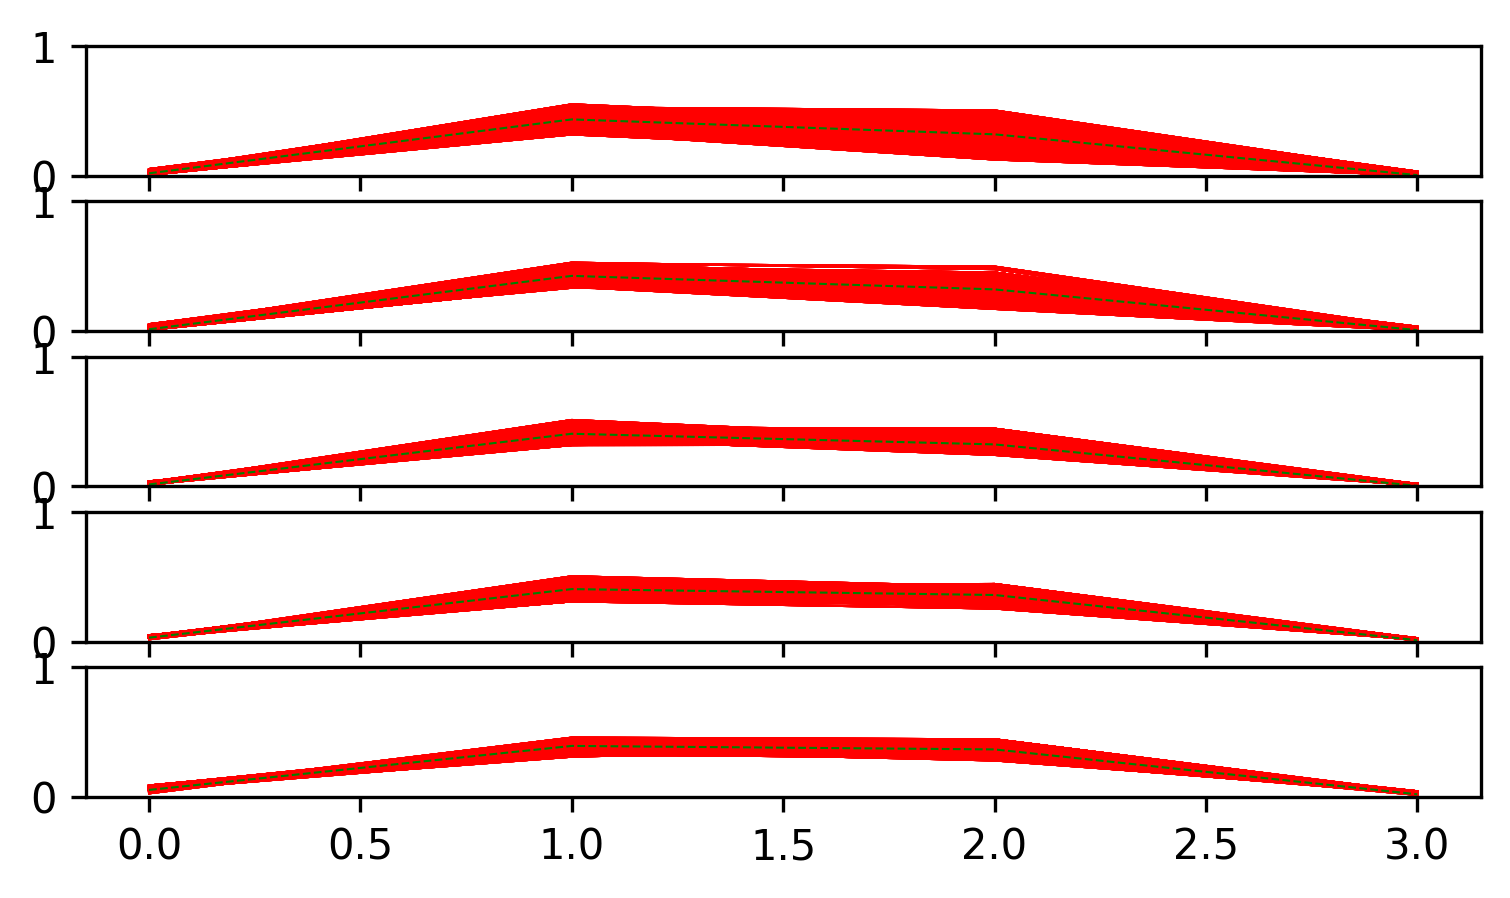

In [7]:
# Plot generated or reconstructed features
plt.rcParams['figure.dpi'] = 300
col = ['k','b','r','g','c','y','m']
fig = plt.figure()

# number of channels
ch_max = x_noise.shape[1]

# number of classes
cl_max = y_train.shape[1]

# loop through channels
for i in range(0,ch_max-1):
    ax = plt.subplot(6,1,i+1)

    # loop through classes
    for cl in range(2,3):
        # index inputs from current class
        x_noise_cl = x_noise[y_train[:,cl]==1,i,:]
        x_clean_cl = x_clean[y_train[:,cl]==1,i,:]
        dec_ind = gen_clf == cl

        ## plot all noisy features
        # for x_all in range(0,x_noise_cl.shape[0]):
        #     ax.plot(x_noise_cl[x_all,:,0],col[cl],linewidth=1)

        ## plot all clean features
        for x_all in range(0,x_clean_cl.shape[0]):
            ax.plot(x_clean_cl[x_all,:,0],col[cl],linewidth=.5,linestyle='-')

        ## plot all decoder output
        # max_gen = 100
        # ax.plot(np.transpose(dec_out[dec_ind,i,:,0][:max_gen,:]),col[cl+1],linewidth=.5,linestyle='--')
        
        ## plot mean of noisy features
        # ax.plot(np.mean(x_cl[:x_cl.shape[0],:,0],axis=0),col[cl],linewidth=1)

        ## plot mean of clean features
        # ax.plot(np.mean(x_clean_cl[:x_clean_cl.shape[0],:,0],axis=0),col[cl],linewidth=1,linestyle=':')

        ## plot mean of reconstructed output
        # rec_cl = dec_out[y_train[:,cl]==1,i,:]
        # ax.plot(np.mean(rec_cl[:,:,0],axis=0),col[cl],linewidth=1,linestyle='--')
        
        ## plot mean of decoder output
        ax.plot(np.mean(np.transpose(dec_out[dec_ind,i,:,0]),axis=1),col[cl+1],linewidth=.5,linestyle='--')

    ax.set_ylim([0,1])

In [3]:
acc_all, acc_noise, acc_clean, file_name = lp.loop_test(raw, params, sub_type, dt = 'cv', sparsity=True, load=True, batch_size=128, latent_dim=4, epochs=50,train_scale=5, n_train='fullgaussflat4', n_test='partgauss2',feat_type='feat', noise=True)

Running sub 1, model 2, latent dim 4
Running sub 1, model 2, latent dim 4
Running sub 1, model 2, latent dim 4
Running sub 1, model 2, latent dim 4


In [4]:
sub_all = acc_all[0,...]
sub_clean = acc_clean[0,...]
sub_noise = acc_noise[0,...]

In [5]:
## Plot training metrics trajectories
# initialize parameters
train_grp = 2
dt = 'cv'
feat_type = 'feat'
latent_dim = 5
epochs = 30
n_train = 'fullgaussflat4'
train_scale = 5
foldername = 'models' + '_' + str(train_grp) + '_' + dt
batch_size = 128
n_test = 0
lr = 0.001

# initialize loss and accuracy matrices
loss = np.full([4,4,epochs],np.nan)
val_loss = np.full([4,4,epochs],np.nan)
acc = np.full([4,4,epochs],np.nan)
val_acc = np.full([4,4,epochs],np.nan)

# loop through subjects
for sub in range(1,2):#6):
    # loop through cross validations
    for cv in range(1,5):
        # load data
        filename = foldername + '/' + sub_type + str(sub) + '_' + feat_type + '_dim_' + str(latent_dim) + '_ep_' + str(epochs) + '_bat_' + str(batch_size) + '_' + n_train + '_' + str(train_scale) + '_lr_' + str(int(lr*10000)) 
        filename += '_cv_'+ str(cv) + '_sparse'
        with open(filename + '_hist.p', 'rb') as f:
            svae_hist, sae_hist, cnn_hist, vcnn_hist = pickle.load(f)

        svae_hist = np.transpose(svae_hist)

        # compile losses and accuracies (uncomment back if all models have same # epochs)
        loss[cv-1,:2,:] = np.array([svae_hist[2,:], sae_hist['loss']])#, cnn_hist['loss'], vcnn_hist['loss']])
        val_loss[cv-1,:2,:] = np.array([svae_hist[9,:], sae_hist['val_loss']])#, cnn_hist['val_loss'], vcnn_hist['val_loss']])
        acc[cv-1,:2,:] = np.array([svae_hist[5,:], sae_hist['accuracy']])#, cnn_hist['accuracy'], vcnn_hist['accuracy']])
        val_acc[cv-1,:2,:] = np.array([svae_hist[-2,:], sae_hist['val_accuracy']])#, cnn_hist['val_accuracy'], vcnn_hist['val_accuracy']])

        # 0-30 for 30 epochs
        loss[cv-1,2:,0:30] = np.array([cnn_hist['loss'], vcnn_hist['loss']])
        val_loss[cv-1,2:,0:30] = np.array([cnn_hist['val_loss'], vcnn_hist['val_loss']])
        acc[cv-1,2:,0:30] = np.array([cnn_hist['accuracy'], vcnn_hist['clf_accuracy']])
        val_acc[cv-1,2:,0:30] = np.array([cnn_hist['val_accuracy'], vcnn_hist['val_clf_accuracy']])

    # load results
    resultsfile = filename
    # with open(resultsfile + '_results.p', 'rb') as f:
    #     acc_all, acc_clean, acc_noise = pickle.load(f)

    # average metrics over cvs
    ave_loss = np.mean(loss,axis=0)
    ave_val_loss = np.mean(val_loss,axis=0)
    ave_acc = np.mean(acc,axis=0)
    ave_val_acc = np.mean(val_acc,axis=0)

    # plot metrics over epochs
    plt.figure(sub)
    for i in range(0,4):
        ax = plt.subplot(2,2,i+1)
        ax.plot(ave_loss[i])
        ax.plot(ave_val_loss[i])
        # ax.set_ylim(0,5)
    plt.figure(sub+1)
    for i in range(0,4):
        ax2 = plt.subplot(2,2,i+1)
        ax2.plot(ave_acc[i])
        ax2.plot(ave_val_acc[i])
        ax2.set_ylim(0,1)

KeyError: 'clf_accuracy'

In [7]:
# Load noise results
sub_all, sub_noise, sub_clean, ave_all, ave_noise, ave_clean = lp.ave_results(params, sub_type, train_grp=2, feat_type='feat',epochs=30,n_train='fullgaussflat4',train_scale=5,n_test='partgauss2', latent_dim=4,loop_i='noise', dt='cv')
sub_all, sub_noise, sub_clean, flat_ave_all, flat_ave_noise, flat_ave_clean = lp.ave_results(params, sub_type, train_grp=2, feat_type='feat',epochs=30,n_train='fullgaussflat4',train_scale=5,n_test='partflat2', latent_dim=4,loop_i='noise',dt='cv')

NameError: name 'flat_ave_noise' is not defined

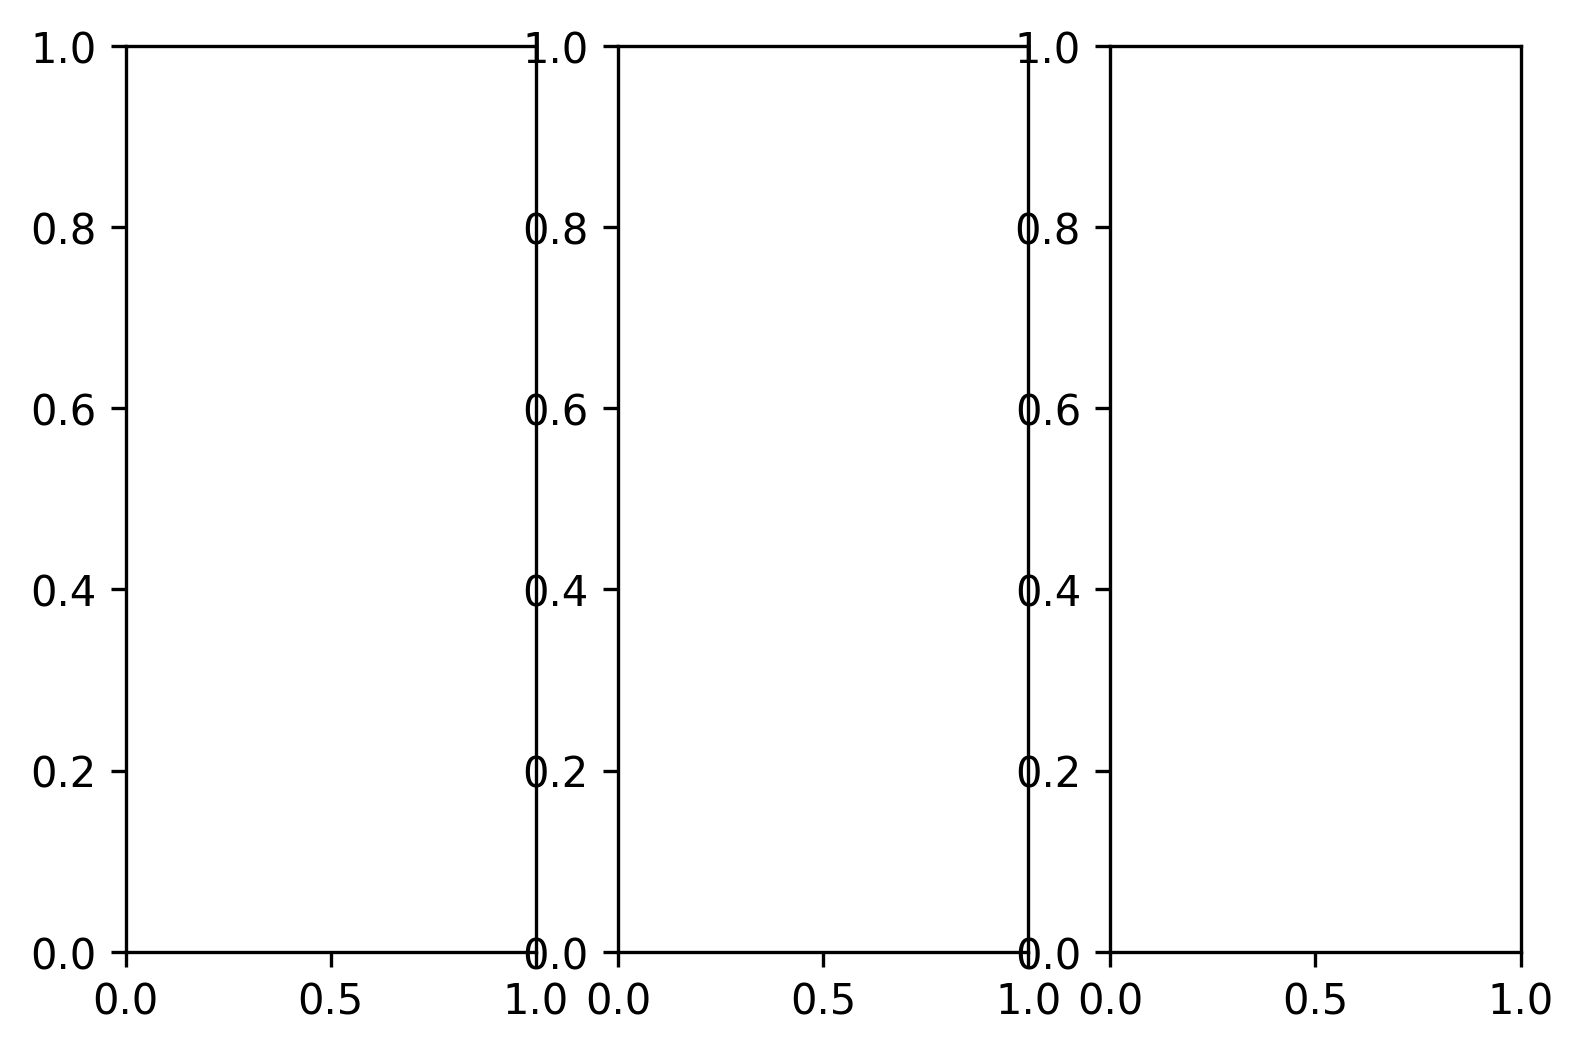

In [7]:
# Plot accuracy vs. noise
fig,ax = plt.subplots(1,3)
for i in range(0,4):
    ax[0].plot(np.hstack((flat_ave_noise[:,i],ave_noise[:,i])),'-o')
for i in range(4,9):    
    ax[1].plot(np.hstack((flat_ave_noise[:,i],ave_noise[:,i])),'-o')
for i in range(9,14):    
    ax[2].plot(np.hstack((flat_ave_noise[:,i],ave_noise[:,i])),'--o')
ax[0].set_ylabel('Accuracy')
fig.text(0.5, 0, 'Type of Noise', ha='center')
ax[0].legend(['svcnn','sae','cnn','vcnn'])
ax[1].legend(['svcnn-lda','sae-lda','cnn-lda','vcnn-lda','rec-lda'])
ax[2].legend(['LDA','LDA-corrupt','QDA','QDA-corrupt','ch'])
ax[1].set_yticks([])
ax[2].set_yticks([])
for i in range(0,3):
    ax[i].set_ylim(0,1)
    ax[i].set_xticks(range(0,6))
    ax[i].set_xticklabels(['Flat','1','2','3','4','5'])

fig.set_tight_layout(True)

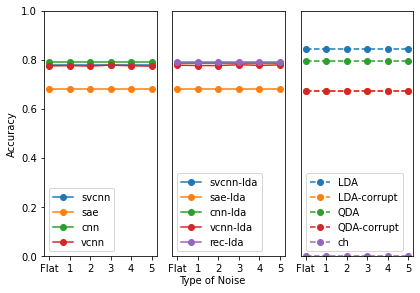

In [10]:
# Plot accuracy vs. noise
fig,ax = plt.subplots(1,3)
for i in range(0,4):
    ax[0].plot(np.hstack((flat_ave_clean[:,i],ave_clean[:,i])),'-o')
for i in range(4,9):    
    ax[1].plot(np.hstack((flat_ave_clean[:,i],ave_clean[:,i])),'-o')
for i in range(9,14):    
    ax[2].plot(np.hstack((flat_ave_clean[:,i],ave_clean[:,i])),'--o')
ax[0].set_ylabel('Accuracy')
fig.text(0.5, 0, 'Type of Noise', ha='center')
ax[0].legend(['svcnn','sae','cnn','vcnn'])
ax[1].legend(['svcnn-lda','sae-lda','cnn-lda','vcnn-lda','rec-lda'])
ax[2].legend(['LDA','LDA-corrupt','QDA','QDA-corrupt','ch'])
ax[1].set_yticks([])
ax[2].set_yticks([])
for i in range(0,3):
    ax[i].set_ylim(0,1)
    ax[i].set_xticks(range(0,6))
    ax[i].set_xticklabels(['Flat','1','2','3','4','5'])

fig.set_tight_layout(True)

In [3]:
# Loop through noise
acc_all, acc_noise, acc_clean, file_name = lp.loop_noise(raw, params, sub_type, load=False, n_train='fullgaussflat4', train_scale=5, n_test=0,epochs=30, batch_size = 128, sparsity=True,dt='cv',feat_type='feat',noise=True, latent_dim=4)

10 - clf_loss: 0.7969 - decoder_accuracy: 0.0039 - clf_accuracy: 0.6803 - val_loss: 1.0422 - val_decoder_loss: 0.0800 - val_clf_loss: 0.9572 - val_decoder_accuracy: 0.0020 - val_clf_accuracy: 0.6190
Epoch 11/30
18900/18900 [==============================] - 2s 126us/sample - loss: 0.8524 - decoder_loss: 0.0848 - clf_loss: 0.7650 - decoder_accuracy: 0.0039 - clf_accuracy: 0.6941 - val_loss: 1.0159 - val_decoder_loss: 0.0789 - val_clf_loss: 0.9367 - val_decoder_accuracy: 0.0020 - val_clf_accuracy: 0.6186
Epoch 12/30
18900/18900 [==============================] - 2s 115us/sample - loss: 0.8229 - decoder_loss: 0.0882 - clf_loss: 0.7323 - decoder_accuracy: 0.0039 - clf_accuracy: 0.7081 - val_loss: 0.9926 - val_decoder_loss: 0.0857 - val_clf_loss: 0.9000 - val_decoder_accuracy: 0.0020 - val_clf_accuracy: 0.6271
Epoch 13/30
18900/18900 [==============================] - 2s 114us/sample - loss: 0.8014 - decoder_loss: 0.0913 - clf_loss: 0.7074 - decoder_accuracy: 0.0039 - clf_accuracy: 0.7258 -

## Reconstruction Loop

In [3]:
dec_out, clf_out, enc_out, x_test_noise, x_test_vae, y_test_clean, filename = lp.loop_recon(raw, params, sub_type, dt='cv', sparsity=True, load=True, n_train='fullgaussflat4',n_test='partgauss1', feat_type='feat', noise=True, lr=0.001)

Running sub 1, model 2, latent dim 4


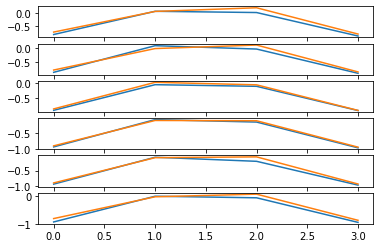

In [7]:
fig,ax = plt.subplots(6,1)
for i in range(6):
    ax[i].plot(np.squeeze(dec_out[1350,i,:,:]))
    ax[i].plot(np.squeeze(x_test_vae[1350,i,:,:]))

## Latent Dimension Loop

In [ ]:
# loop through latent dimensions
sub_all, sub_noise, sub_clean, file_name = lp.loop_alldim(raw, params, sub_type, load=False, n_train='gaussflat', train_scale=3, n_test='gauss', test_scale=1,epochs=30, sparsity=True, dt='0414')

In [ ]:
# load results from latent dimension loop, sparse vs. not sparse
sub_all, sub_noise, sub_clean, sparse_all, sparse_noise, sparse_clean = lp.load_results(params, sub_type=sub_type,sparsity=True, dt='0414')
sub_all, sub_noise, sub_clean, ave_all, ave_noise, ave_clean = lp.load_results(params, sub_type=sub_type,sparsity=False, dt='0414')

In [ ]:
# Plot accuracy vs. latent dimension
fig,ax = plt.subplots(1,2)
for i in range(0,4):
    ax[0].plot(ave_noise[:,i],'-o')
    ax[1].plot(sparse_noise[:,i],'-o')
ax[0].set_ylabel('Accuracy')
fig.text(0.5, 0.04, 'Latent Dimension', ha='center')
ax[0].set_ylim(0.5,1)
ax[1].set_ylim(0.5,1)
ax[0].legend(['svcnn','sae','cnn','vcnn'])